In [1]:
#Liberías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from matplotlib import pyplot
from numpy import where
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer, MissingIndicator

from boruta import BorutaPy

In [2]:
# Yo cargaría el dataframe, para no repetir pasos
df = pd.read_parquet('../data/full_data_initial.parquet')

In [3]:
### HAY QUE MIRAR ESTO. SI LO HACEMOS, CAMBIA LA MORTALIDAD GENERAL DEL DATASET

#TODO:  ¿peatones (df['passenger_role'] == "99")?

# Remove non-driver rows

df = df.loc[(df['passenger_role'] == "11") | (df['passenger_role'] == "99")]

# Drop the role column

df = df.drop('passenger_role', axis = 1)
# por qué hacemos esto? por que el número de personas que van en un coche antes de un accidente no es una variable predecible
# y por lo tanto hemos de tener en cuenta únicamente al conductor, que en un caso hipotético de ponernos en el lugar de una
# empresa aseguradora, será el individuo sobre el cual tendremos información

# Además, nos evita problemas a la hora de entrenar los modelos ya que sería posible que varios registros del mismo coche,
# que inevitablemente tienen una correlación muy alta respecto de la variable objetivo, sesgando nuestros modelos.

In [4]:
#TODO: crear columna passenger count si es posible 
#Una forma sería unir tablas por el indice en df está intacto en df2 está reseteado
#Esto solo se podria hacer si partimos del mismo df guardado del descrptive
df2 = pd.read_parquet('../data/vehicle_data_initial.parquet')

### Valores Missing pt.1: categóricas y eliminar

In [5]:
# Análisis Nulos
nulos_col = pd.merge(df.isnull().sum().sort_values().to_frame('missing_value').reset_index(),
         df.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
nulos_col['columns_percentage'] = nulos_col['missing_value']/df.shape[0]
nulos_col.sort_values(['missing_value', 'feature_type', 'columns_percentage'], ascending=False)

,index,missing_value,feature_type,columns_percentage
17,vehicle_age,497550,float64,0.121817
16,passenger_safety,460486,object,0.112743
15,crash_place,345281,object,0.084537
14,road_slope,287521,object,0.070395
13,passenger_age,210849,float64,0.051623
12,traffic_state,157226,object,0.038494
11,passenger_sex,153774,float64,0.037649
10,crash_type,131908,object,0.032296
9,passenger_type,62699,object,0.015351
8,crash_weather,58033,object,0.014208


In [6]:
# Change nas for "NA" string in order to be able to encode it. (Maybe) we could've saved time earlier by not removing U,UU... but there still were NAs

na_cols = ["crash_type", "crash_place", "crash_weather", "surface_state", "road_slope", "traffic_state", "vehicle_type", "passenger_safety", "passenger_type"]

for col in na_cols:
    df[col].fillna("NA", inplace=True)
    
#Borramos NAs vehicles_involved (muy pocos)
df = df[df['vehicles_involved'].notna()]

### Outliers

In [7]:
# Remove rows with an outlier vehicle_age
df = df.loc[(df['vehicle_age'] < 30) | (df['vehicle_age'].isnull())]

# Removes rows with outlier vehicles_involved
df = df.loc[(df['vehicles_involved'] < 6)  | (df['vehicles_involved'].isnull())]

### Tramificación Variable Temporales

In [8]:
#Transform month column to quarters
df['month'] = (df['month']-1)//3 + 1
df = df.rename({'month': 'quarter'}, axis= 1)

In [9]:
# Transform weekday column
df['weekday'] = df['weekday'].replace({6:3, 7:3, 1:2, 4:2, 5:2, 2:1, 3:1})

In [10]:
# Transform hour column
df['hour'] = df['hour'].replace({0:1, 1:1, 2:1, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3, 11:4, 12:4, 13:4, 14:4, 15:4, 16:4, 17:4, 18:4, 19:5, 20:5, 21:5, 22:6, 23:6})

### Train Test Split
Eliminar outliers y missings podemos hacerlo antes del split. Sin embargo, para imputar debemos hacerlo después con valores del Train

In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(df.drop(columns=['fatality']), df['fatality'], test_size=0.20, random_state=0)
#xtrain = xtrain.drop(columns="index")
#xtest = xtest.drop(columns="index")

In [12]:
# Mean encoding
encode_cols = ["crash_type", "crash_place", "crash_weather", "surface_state", "road_slope", "traffic_state", "vehicle_type", "passenger_safety", "passenger_type"]

for i in encode_cols:
    encoder = TargetEncoder()
    encoder.fit(xtrain[i], ytrain)
    xtest[i] = encoder.transform(xtest[i])

for i in encode_cols:
    encoder = TargetEncoder()
    xtrain[i] = encoder.fit_transform(xtrain[i], ytrain)


C:\Users\Usuario\anaconda3\envs\core_models\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### Encoding Variables categóricas

In [13]:
# One-hot-encoding
columnasfecha = ["hour", "weekday", "quarter", "passenger_sex"]

for i in columnasfecha:
    onehotencoder = OneHotEncoder(handle_unknown="ignore")
    array = xtrain[i].values.reshape(-1,1)
    df_temp = onehotencoder.fit_transform(array)
    colnames = onehotencoder.get_feature_names([i])
    df_temp = pd.DataFrame(df_temp.toarray(), columns = colnames)
    xtrain.index = df_temp.index
    xtrain = pd.concat([df_temp, xtrain], axis=1)
# We get rid of the not encoded columns
xtrain = xtrain.drop(columns = columnasfecha)
if "passenger_sex_nan" in xtrain.columns:
    xtrain = xtrain.drop(columns = "passenger_sex_nan")


# Same for xtest
for i in columnasfecha:
    onehotencoder = OneHotEncoder(handle_unknown="ignore")
    array = xtest[i].values.reshape(-1,1)
    df_temp = onehotencoder.fit_transform(array)
    colnames = onehotencoder.get_feature_names([i])
    df_temp = pd.DataFrame(df_temp.toarray(), columns = colnames)
    xtest.index = df_temp.index
    xtest = pd.concat([df_temp, xtest], axis=1)
xtest = xtest.drop(columns = columnasfecha)
if "passenger_sex_nan" in xtest.columns:
    xtest = xtest.drop(columns = "passenger_sex_nan")

C:\Users\Usuario\anaconda3\envs\core_models\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\anaconda3\envs\core_models\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\anaconda3\envs\core_models\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Usuario\anaconda3\envs\core_models\lib\site-packages\sklearn\utils\deprec

In [14]:
ytrain.index = xtrain.index
ytest.index = xtest.index

In [15]:
#Reordenamos columnas
new_cols = ['year','quarter_1','quarter_2','quarter_3','quarter_4','weekday_1','weekday_2','weekday_3','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','vehicles_involved','crash_type','crash_place',
            'crash_weather','surface_state','road_slope','traffic_state','vehicle_type','vehicle_age','passenger_age','passenger_sex_0.0','passenger_sex_1.0','passenger_safety','passenger_type']


xtrain = xtrain.reindex(columns=new_cols)
xtest = xtest.reindex(columns=new_cols)

#### Comprobamos que Test y Train son similares

In [16]:
#Train
pd.concat([xtrain, pd.DataFrame(ytrain)]).describe()

,year,quarter_1,quarter_2,quarter_3,quarter_4,weekday_1,weekday_2,weekday_3,hour_1,hour_2,...,road_slope,traffic_state,vehicle_type,vehicle_age,passenger_age,passenger_sex_0.0,passenger_sex_1.0,passenger_safety,passenger_type,fatality
count,3.240488e+06,3.240488e+06,3.240488e+06,3.240488e+06,3.240488e+06,3.240488e+06,3.240488e+06,3.240488e+06,3.240488e+06,3.240488e+06,...,3.240488e+06,3.240488e+06,3.240488e+06,2.843293e+06,3.073868e+06,3.240488e+06,3.240488e+06,3.240488e+06,3.240488e+06,3.240488e+06
mean,2.006016e+03,2.308893e-01,2.361496e-01,2.672107e-01,2.657504e-01,2.955092e-01,4.648136e-01,2.396772e-01,6.241652e-02,1.178912e-01,...,1.492831e-02,1.492831e-02,1.492831e-02,7.412254e+00,3.940235e+01,3.682982e-01,5.942170e-01,1.492831e-02,1.492831e-02,1.492831e-02
std,4.570428e+00,4.214018e-01,4.247152e-01,4.425033e-01,4.417320e-01,4.562714e-01,4.987605e-01,4.268865e-01,2.419106e-01,3.224793e-01,...,6.896515e-03,7.400496e-03,9.086226e-03,5.282464e+00,1.676576e+01,4.823429e-01,4.910430e-01,1.109513e-02,4.233847e-03,1.212661e-01
min,1.999000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,6.338167e-03,0.000000e+00,3.584229e-03,-2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.162285e-02,8.033519e-03,0.000000e+00
25%,2.002000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.253104e-02,5.038715e-03,1.199126e-02,3.000000e+00,2.500000e+01,0.000000e+00,0.000000e+00,1.162285e-02,1.381770e-02,0.000000e+00
50%,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.253104e-02,2.135241e-02,1.199126e-02,7.000000e+00,3.800000e+01,0.000000e+00,1.000000e+00,1.162285e-02,1.381770e-02,0.000000e+00
75%,2.010000e+03,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.253104e-02,2.135241e-02,1.199126e-02,1.100000e+01,5.100000e+01,1.000000e+00,1.000000e+00,1.324231e-02,1.381770e-02,0.000000e+00
max,2.014000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,3.601067e-02,7.446809e-02,7.163682e-02,2.900000e+01,9.900000e+01,1.000000e+00,1.000000e+00,7.705106e-02,2.911187e-02,1.000000e+00


In [17]:
#Test
pd.concat([xtest, pd.DataFrame(ytest)]).describe()

,year,quarter_1,quarter_2,quarter_3,quarter_4,weekday_1,weekday_2,weekday_3,hour_1,hour_2,...,road_slope,traffic_state,vehicle_type,vehicle_age,passenger_age,passenger_sex_0.0,passenger_sex_1.0,passenger_safety,passenger_type,fatality
count,810122.000000,810122.000000,810122.000000,810122.000000,810122.000000,810122.000000,810122.000000,810122.000000,810122.000000,810122.000000,...,810122.000000,810122.000000,810122.000000,711275.000000,768288.000000,810122.000000,810122.000000,810122.000000,810122.000000,810122.000000
mean,2006.012581,0.231102,0.236255,0.267824,0.264819,0.295341,0.465194,0.239465,0.062499,0.117682,...,0.014929,0.014924,0.014929,7.413103,39.408740,0.367389,0.594886,0.014949,0.014919,0.015395
std,4.565851,0.421538,0.424781,0.442826,0.441237,0.456196,0.498787,0.426757,0.242060,0.322232,...,0.006893,0.007393,0.009108,5.278809,16.778928,0.482094,0.490914,0.011141,0.004221,0.123119
min,1999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006338,0.000000,0.003584,-2.000000,1.000000,0.000000,0.000000,0.011623,0.008034,0.000000
25%,2002.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.012531,0.005039,0.011991,3.000000,25.000000,0.000000,0.000000,0.011623,0.013818,0.000000
50%,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.012531,0.021352,0.011991,7.000000,38.000000,0.000000,1.000000,0.011623,0.013818,0.000000
75%,2010.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.012531,0.021352,0.011991,11.000000,51.000000,1.000000,1.000000,0.013242,0.013818,0.000000
max,2014.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.036011,0.074468,0.071637,29.000000,99.000000,1.000000,1.000000,0.077051,0.029112,1.000000


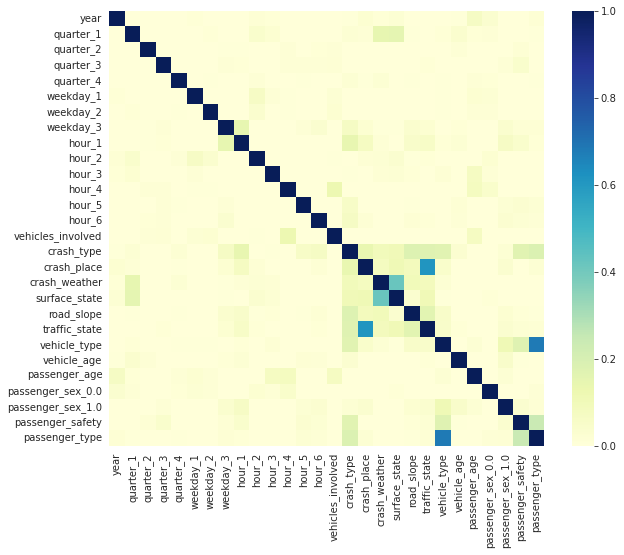

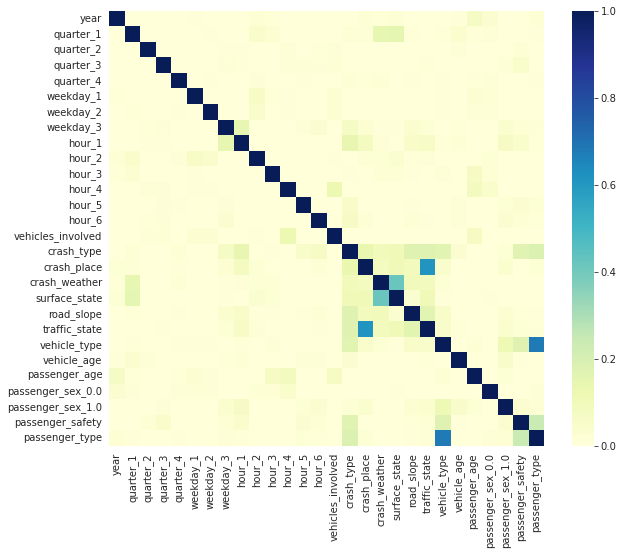

In [18]:
#Correlación de Spearman con todas las variables
plt.figure(figsize=(10,8))
with sns.axes_style("white"):
  ax = sns.heatmap(xtrain.corr('spearman'),vmin=0., vmax=1, square=True, cmap="YlGnBu")
plt.show()

plt.figure(figsize=(10,8))
with sns.axes_style("white"):
  ax = sns.heatmap(xtest.corr('spearman'),vmin=0., vmax=1, square=True, cmap="YlGnBu")
plt.show()

### Valores Missing pt.2: Imputar

In [19]:
# Análisis Nulos
nulos_col = pd.merge(xtrain.isnull().sum().sort_values().to_frame('missing_value').reset_index(),
         xtrain.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
nulos_col['columns_percentage'] = nulos_col['missing_value']/xtrain.shape[0]
nulos_col.sort_values(['missing_value', 'feature_type', 'columns_percentage'], ascending=False)

,index,missing_value,feature_type,columns_percentage
27,vehicle_age,397195,float64,0.122573
26,passenger_age,166620,float64,0.051418
1,passenger_sex_1.0,0,float64,0.000000
2,passenger_sex_0.0,0,float64,0.000000
3,vehicle_type,0,float64,0.000000
4,traffic_state,0,float64,0.000000
5,road_slope,0,float64,0.000000
6,surface_state,0,float64,0.000000
7,crash_weather,0,float64,0.000000
8,crash_place,0,float64,0.000000


La variable vehicles_involved apenas tiene nulos por lo que vamos a eliminar los registros. Para passenger_age y vehicle_age vamos a ver de nuevo como se distribuyen ambas variables y tomaremos una decisión sobre como imputar los valores nulos

#### Gráfico distribución de las variables

<AxesSubplot:xlabel='passenger_age'>

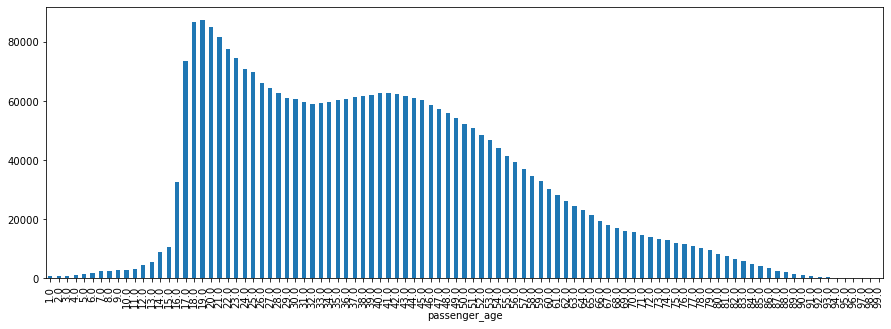

In [20]:
#passenger_age plot
plt.figure(figsize=(15,5))
pd.concat([xtrain, pd.DataFrame(ytrain)], axis=1).groupby(('passenger_age'))['fatality'].count().plot(kind="bar")

Encontramos algo curioso que no habíamos podido ver en el análisis descriptivo ya que vimos la distribución de edad con todos los pasajeros. Existen registros de conductores con una edad muy corta. ¡Tres, cuatro o cinco años! Outliers claramente erróneos que no deberíamos tener en cuenta. Acudiendo a la fuente oficial de los datos hemos encontrado la siguiente respuesta a la consulta de un usuario que confirma nuestras sospechas:  
*"The data in the NCDB are as reported by the provinces and territories. In some instances a child can be coded as being the driver when they are sitting on the lap of the real driver. In other cases, this would be an error, but there would be no way to determine which cases are the latter"* https://open.canada.ca/data/en/dataset/1eb9eba7-71d1-4b30-9fb1-30cbdab7e63a  
Con estos valores seguiremos la misma estrategia de imputación que empleemos con los missings

In [21]:
#Imputaremos los NAs un  valor fijo en base a un estadístico de su distribución 
print("La Media es",xtrain['passenger_age'].mean())
print("La Mediana es", xtrain['passenger_age'].median())
print("La Moda es",xtrain['passenger_age'].mode().values)

La Media es 39.40235299629002
La Mediana es 38.0
La Moda es [19.]


<AxesSubplot:xlabel='vehicle_age'>

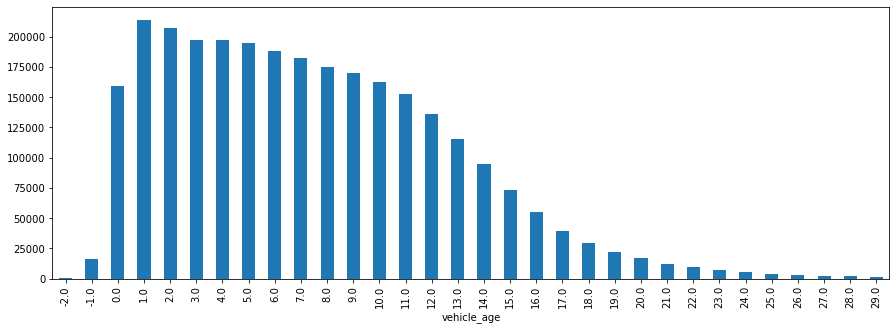

In [22]:
#vehicle_age plot
plt.figure(figsize=(15,5))
pd.concat([xtrain, pd.DataFrame(ytrain)], axis=1).groupby(('vehicle_age'))['fatality'].count().plot(kind="bar")

In [23]:
# Imputaremos los NAs un  valor fijo en base a un estadístico de su distribución 
print("La Media es",xtrain['vehicle_age'].mean())
print("La Mediana es", xtrain['vehicle_age'].median())
print("La Moda es",xtrain['vehicle_age'].mode().values)

La Media es 7.412253679096738
La Mediana es 7.0
La Moda es [1.]


In [24]:
# Transformamos Outliers en nulos para imputar
xtest['passenger_age'][(xtest['passenger_age'] < 13)] = np.nan
xtrain['passenger_age'][(xtrain['passenger_age'] < 13)] = np.nan

<ipython-input-24-d8c674f16029>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtest['passenger_age'][(xtest['passenger_age'] < 13)] = np.nan
<ipython-input-24-d8c674f16029>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain['passenger_age'][(xtrain['passenger_age'] < 13)] = np.nan


In [25]:
# Imputamos nulos
simp = SimpleImputer(strategy='median', missing_values=np.nan)
simp = simp.fit(xtrain[['vehicle_age', 'passenger_age']])
xtrain[['vehicle_age', 'passenger_age']] = simp.transform(xtrain[['vehicle_age', 'passenger_age']])
xtest[['vehicle_age', 'passenger_age']] = simp.transform(xtest[['vehicle_age', 'passenger_age']])

In [26]:
floats = ['quarter_1', "quarter_2", "quarter_3", "quarter_4", "weekday_1", "weekday_2", "weekday_3", "hour_1", "hour_2", "hour_3", "hour_4", "hour_5", "hour_6", "vehicles_involved", "vehicle_age", "passenger_age", "passenger_sex_0.0", "passenger_sex_1.0"]
floats2 = ['crash_type', "crash_place", "crash_weather", "surface_state", "road_slope", "traffic_state", "vehicle_type", "passenger_safety", "passenger_type"]

for i in floats:
    xtrain[i] = xtrain[i].astype('int8')
    xtest[i] = xtest[i].astype('int8')

# This might give us problems (atleast for Lasso)
#for i in floats2:
#    xtrain[i] = xtrain[i].astype('float32')
#    xtest[i] = xtest[i].astype('float32')
xtrain['year'] = xtrain['year'].astype('int16')
xtest['year'] = xtest['year'].astype('int16')

In [27]:
xtrain

,year,quarter_1,quarter_2,quarter_3,quarter_4,weekday_1,weekday_2,weekday_3,hour_1,hour_2,...,surface_state,road_slope,traffic_state,vehicle_type,vehicle_age,passenger_age,passenger_sex_0.0,passenger_sex_1.0,passenger_safety,passenger_type
0,2012,0,1,0,0,0,1,0,0,0,...,0.015074,0.012531,0.011829,0.011991,17,77,0,1,0.011623,0.013818
1,2008,1,0,0,0,0,1,0,0,0,...,0.013393,0.012531,0.021352,0.011991,7,46,1,0,0.013242,0.013818
2,2003,0,0,0,1,0,1,0,0,0,...,0.013393,0.012531,0.021352,0.008034,7,55,1,0,0.028932,0.008034
3,2011,0,1,0,0,0,1,0,0,0,...,0.013393,0.032555,0.014890,0.011991,6,41,1,0,0.011623,0.013818
4,1999,0,0,1,0,1,0,0,0,0,...,0.015074,0.012531,0.021352,0.020056,3,50,0,1,0.016130,0.013818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3240483,2007,1,0,0,0,0,0,1,1,0,...,0.015667,0.012531,0.021352,0.011991,18,35,0,1,0.011623,0.013818
3240484,2002,0,1,0,0,0,1,0,0,0,...,0.015074,0.019158,0.011829,0.011991,7,24,0,1,0.011623,0.013818
3240485,2006,0,0,0,1,1,0,0,0,0,...,0.013393,0.012531,0.021352,0.028640,7,50,0,1,0.013242,0.029112
3240486,2004,1,0,0,0,0,1,0,0,1,...,0.018451,0.019158,0.021352,0.011991,15,17,1,0,0.011623,0.013818


In [28]:
#Escalado de variables

## Voy a comprobar si esto merece la pena o no hacerlo
scaler = StandardScaler()
model_scaled = scaler.fit(xtrain[['vehicle_age', 'passenger_age', 'vehicles_involved']])
xtrain[['vehicle_age', 'passenger_age', 'vehicles_involved']] = pd.DataFrame(scaler.transform(xtrain[['vehicle_age', 'passenger_age', 'vehicles_involved']]))
xtest[['vehicle_age', 'passenger_age', 'vehicles_involved']] = pd.DataFrame(scaler.transform(xtest[['vehicle_age', 'passenger_age', 'vehicles_involved']]))

# Quizás hacer el scaling solo en las columnas en las que hemos hecho el mean encoding, y no en las numéricas. Eso si al final lo utilizamos.

In [29]:
xtrain

,year,quarter_1,quarter_2,quarter_3,quarter_4,weekday_1,weekday_2,weekday_3,hour_1,hour_2,...,surface_state,road_slope,traffic_state,vehicle_type,vehicle_age,passenger_age,passenger_sex_0.0,passenger_sex_1.0,passenger_safety,passenger_type
0,2012,0,1,0,0,0,1,0,0,0,...,0.015074,0.012531,0.011829,0.011991,1.947131,2.325870,0,1,0.011623,0.013818
1,2008,1,0,0,0,0,1,0,0,0,...,0.013393,0.012531,0.021352,0.011991,-0.073075,0.399957,1,0,0.013242,0.013818
2,2003,0,0,0,1,0,1,0,0,0,...,0.013393,0.012531,0.021352,0.008034,-0.073075,0.959093,1,0,0.028932,0.008034
3,2011,0,1,0,0,0,1,0,0,0,...,0.013393,0.032555,0.014890,0.011991,-0.275096,0.089326,1,0,0.011623,0.013818
4,1999,0,0,1,0,1,0,0,0,0,...,0.015074,0.012531,0.021352,0.020056,-0.881158,0.648462,0,1,0.016130,0.013818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3240483,2007,1,0,0,0,0,0,1,1,0,...,0.015667,0.012531,0.021352,0.011991,2.149152,-0.283431,0,1,0.011623,0.013818
3240484,2002,0,1,0,0,0,1,0,0,0,...,0.015074,0.019158,0.011829,0.011991,-0.073075,-0.966820,0,1,0.011623,0.013818
3240485,2006,0,0,0,1,1,0,0,0,0,...,0.013393,0.012531,0.021352,0.028640,-0.073075,0.648462,0,1,0.013242,0.029112
3240486,2004,1,0,0,0,0,1,0,0,1,...,0.018451,0.019158,0.021352,0.011991,1.543090,-1.401703,1,0,0.011623,0.013818


### Creación de una versión oversample (SMOTE) del dataset

In [38]:
print("Before: ", Counter(ytrain))
oversample = SMOTE(sampling_strategy=0.4, n_jobs=-1)
xtrain_smote, ytrain_smote = oversample.fit_resample(xtrain, ytrain)
print("After: ", Counter(ytrain_smote))

Before:  Counter({0: 3192113, 1: 48375})
After:  Counter({0: 3192113, 1: 1276845})


### Guardado de los frames

In [39]:
xtrain.to_parquet("../data/xtrain.parquet")
xtest.to_parquet("../data/xtest.parquet")
pd.DataFrame(ytrain).to_parquet("../data/ytrain.parquet")
pd.DataFrame(ytest).to_parquet("../data/ytest.parquet")
xtrain_smote.to_parquet("../data/xtrain_smote.parquet")
pd.DataFrame(ytrain_smote).to_parquet("../data/ytrain_smote.parquet")